# Simple Benchmark on $loss(x) = \|I - x^T x\|^2

## Prepare environment

### Install required packages


In [11]:
# Uninstall optax and reinstall just to be sure we're using the latest version
!pip uninstall -q optax -y && pip install -q git+https://github.com/leloykun/optax.git@fc--add-muon
# !pip uninstall -q optax -y && pip install -q -e ~/optax
# Install plotting libraries
!pip install -q matplotlib seaborn

/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


You can comment out the cell above after running it at least once.

### Import required packages

In [1]:
import time
from functools import partial
from typing import Union, Tuple

import jax
import jax.numpy as jnp
import optax

from optax.contrib import muon
# from optax import adam
from dual_scaled_adam import adam
# from psgd_jax.kron import kron as psgd_kron
from dual_scaled_psgd_kron import psgd_kron
from psgd_jax.low_rank_approximation import low_rank_approximation as psgd_lra
# from dual_scaled_psgd_lra import low_rank_approximation as psgd_lra
from psgd_jax.utils import hessian_helper

import matplotlib.pyplot as plt
import seaborn as sns

## Benchmark

### Utils

In [2]:
def loss_fn(x: jax.Array, n: int):
    return jnp.linalg.norm(jnp.eye(n, dtype=x.dtype) - x.T @ x)**2

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn), static_argnames=("n",))

In [3]:
@partial(jax.jit, static_argnums=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
def train(
    x: jax.Array,
    n: int = 2,
    dtype: jnp.dtype = jnp.float32,
    # ["muon", "adam", "psgd_kron", "psgd_lra", "psgd_lra_hess"]
    optimizer_class: str = "muon",
    num_iterations: int = 100,
    learning_rate: float = 0.001,
    ns_coeffs: Union[
      Tuple[float, float, float],
      Tuple[Tuple[float, float, float], ...],
    ] = (3.4445, -4.7750, 2.0315),
    ns_steps: int = 5,
    beta: float = 0.95,
    nesterov: bool = True,
    adaptive: bool = False,
):
    x = x.astype(dtype)
    if optimizer_class == "muon":
        optimizer = muon(
            learning_rate=learning_rate,
            ns_coeffs=ns_coeffs,
            ns_steps=ns_steps,
            beta=beta,
            nesterov=nesterov,
            adaptive=adaptive,
        )
    elif optimizer_class == "adam":
        optimizer = adam(
            learning_rate=learning_rate,
            b1=beta,
            b2=beta,
            nesterov=nesterov,
            adaptive=adaptive,
        )
    elif optimizer_class == "psgd_kron":
        optimizer = psgd_kron(
            learning_rate=learning_rate,
            b1=beta,  # 0.95
            preconditioner_update_probability=1.,
            # preconditioner_lr=learning_rate,
            # preconditioner_lr=1.,
            mu_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_update_precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_grads_precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            adaptive=adaptive,
        )
    elif optimizer_class in ["psgd_lra", "psgd_lra_hess"]:
        optimizer = psgd_lra(
            learning_rate=learning_rate,
            b1=beta,
            uvd_rank_of_approximation=4,
            precond_lr=1.,
            # precond_init_scale=1.,
            mu_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            update_global_norm_clip = n,  # might not be needed
        )
    else:
        raise ValueError(f"Unknown optimizer class: {optimizer_class}")
    opt_state = optimizer.init(x)

    def body_fn(values: tuple[jax.Array, optax.OptState, jax.Array, int], _):
        x, opt_state, rng_key, step = values
        step += 1
        if optimizer_class == "psgd_lra_hess":
            rng_key, subkey = jax.random.split(rng_key)
            loss, grad, hvp, vector, update_precond = hessian_helper(
                rng_key, step, jax.jit(loss_fn, static_argnums=(1,)), x, (n,), False, 1.0
            )
            updates, opt_state = optimizer.update(
                grad, opt_state, None, Hvp=hvp, vector=vector, update_preconditioner=update_precond
            )
        else:
            loss, grad = loss_and_grad_fn(x, n)
            updates, opt_state = optimizer.update(grad, opt_state, x)
        new_x = optax.apply_updates(x, updates)
        return (new_x, opt_state, rng_key, step), loss

    _, losses = jax.lax.scan(body_fn, (x, opt_state, jax.random.PRNGKey(0), 0), length=num_iterations)

    return losses

batch_train = jax.vmap(train, in_axes=(0, None, None, None, None, None, None, None, None, None, None))

### Benchmark optimizer variants

In [4]:
def benchmark_optimizer_variants(
    savefile: str,
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    num_iterations: int=100,
    learning_rate: float=0.1,
    optimizer_to_learning_rate_map: dict[str, float]={},
    ns_steps: int=5,
    beta: float=0.0,
    optimizer_to_beta_map: dict[str, float]={},
    warmup: bool=True,
):
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, shape=(b, n, n), dtype=dtype)

    results = {}
    for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra", "psgd_lra_hess"]:
        for adaptive in [False, True]:
            if optimizer_class in ["psgd_lra", "psgd_lra_hess"] and adaptive:
                continue
            ns_coeffs = (3.4445, -4.7750, 2.0315)
            if warmup:
                _ = batch_train(
                    X,
                    n,
                    dtype,
                    optimizer_class,
                    num_iterations,
                    (
                        learning_rate
                        if len(optimizer_to_learning_rate_map) == 0
                        else optimizer_to_learning_rate_map[optimizer_class]
                    ),
                    ns_coeffs,
                    ns_steps,
                    (
                        beta
                        if len(optimizer_to_beta_map) == 0
                        else optimizer_to_beta_map[optimizer_class]
                    ),
                    True,
                    adaptive,
                )
            t0 = time.perf_counter_ns()
            losses = batch_train(
                X,
                n,
                dtype,
                optimizer_class,
                num_iterations,
                (
                    learning_rate
                    if len(optimizer_to_learning_rate_map) == 0
                    else optimizer_to_learning_rate_map[optimizer_class]
                ),
                ns_coeffs,
                ns_steps,
                (
                    beta
                    if len(optimizer_to_beta_map) == 0
                    else optimizer_to_beta_map[optimizer_class]
                ),
                True,
                adaptive,
            )
            training_time_ns = time.perf_counter_ns() - t0
            optimizer_name = f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}"
            num_inf = jnp.count_nonzero(jnp.isinf(losses))
            num_nan = jnp.count_nonzero(jnp.isnan(losses))
            print(f"[{optimizer_name:<20}]: {num_inf:>6} inf, {num_nan:>6} nan, {training_time_ns/1e6:.2f} ms")
            losses = jnp.where(jnp.isnan(losses), 0.0, losses)
            results[(optimizer_class, adaptive)] = losses.astype(jnp.float32)

    palette = sns.color_palette("Paired", n_colors=len(results))
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, ((optimizer_class, adaptive), all_losses) in enumerate(results.items()):
        idxs = jax.random.choice(key, jnp.arange(b), shape=(20,), replace=False)
        for losses in all_losses[idxs]:
            sns.lineplot(
                losses,
                # alpha=0.02,
                alpha=0.1,
                color=palette[idx],
                linestyle="--",
            )
        x = jnp.arange(1, num_iterations+1)
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            x=x,
            y=median_losses,
            label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
            # linestyle="--" if optimized else "-",
            color=palette[idx],
            linewidth=2.5,
        )
    learning_rate_str = str(learning_rate) if len(optimizer_to_learning_rate_map) == 0 else "opt"
    beta_str = f"{beta:.3f}" if len(optimizer_to_beta_map) == 0 else "opt"
    plt.title(f"Optimizer Variants (beta={beta_str}, lr={learning_rate_str}, dtype={dtype.dtype})\n$loss(x) = || I - x^T x ||^2$")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    if dtype == jnp.bfloat16:
        plt.ylim(bottom=1e-7, top=1e3)
    else:
        plt.ylim(bottom=1e-17, top=1e7)
    plt.yscale("log")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

[Muon                ]:      0 inf,      0 nan, 37.61 ms
[Muon; adaptive      ]:      0 inf, 877798 nan, 33.69 ms
[Adam                ]:      0 inf,      0 nan, 4.39 ms
[Adam; adaptive      ]:      0 inf, 922904 nan, 5.55 ms
PSGD Preconditioners size: 8 elements, 0.00 MB
[Psgd_Kron           ]:      0 inf,      0 nan, 189.30 ms
PSGD Preconditioners size: 8 elements, 0.00 MB
[Psgd_Kron; adaptive ]:      0 inf, 345202 nan, 154.70 ms
[Psgd_Lra            ]:      0 inf,  10176 nan, 376.74 ms
[Psgd_Lra_Hess       ]:      0 inf, 1528357 nan, 398.86 ms


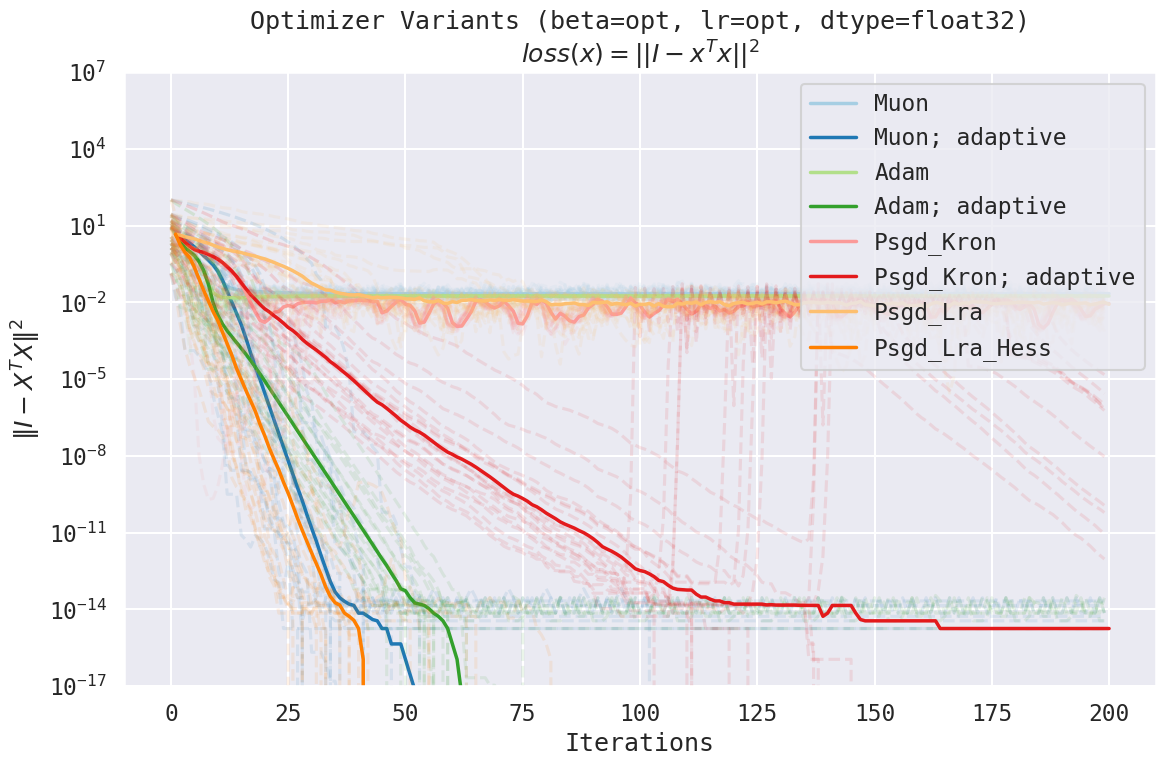

In [5]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_beta=opt.png",
    b=10000,
    num_iterations=200,
    optimizer_to_learning_rate_map={
        "muon": 1e-1,
        "adam": 1e-1,
        "psgd_kron": 5e-2,
        "psgd_lra": 5e-2,
        "psgd_lra_hess": 5e-1,
    },
    optimizer_to_beta_map={
        "muon": 0.5,
        "adam": 0.5,
        "psgd_kron": 0.0,
        "psgd_lra": 0.0,
        "psgd_lra_hess": 0.0,
    },
)

[Muon                ]:      0 inf,      0 nan, 21.26 ms
[Muon; adaptive      ]:      0 inf,      0 nan, 19.99 ms
[Adam                ]:      0 inf,     83 nan, 2.34 ms
[Adam; adaptive      ]:      0 inf,   1988 nan, 3.39 ms
PSGD Preconditioners size: 8 elements, 0.00 MB
[Psgd_Kron           ]:      0 inf,      0 nan, 89.77 ms
PSGD Preconditioners size: 8 elements, 0.00 MB
[Psgd_Kron; adaptive ]:      0 inf,     27 nan, 90.60 ms
[Psgd_Lra            ]:      0 inf,    841 nan, 170.88 ms
[Psgd_Lra_Hess       ]:      0 inf,    942 nan, 212.19 ms


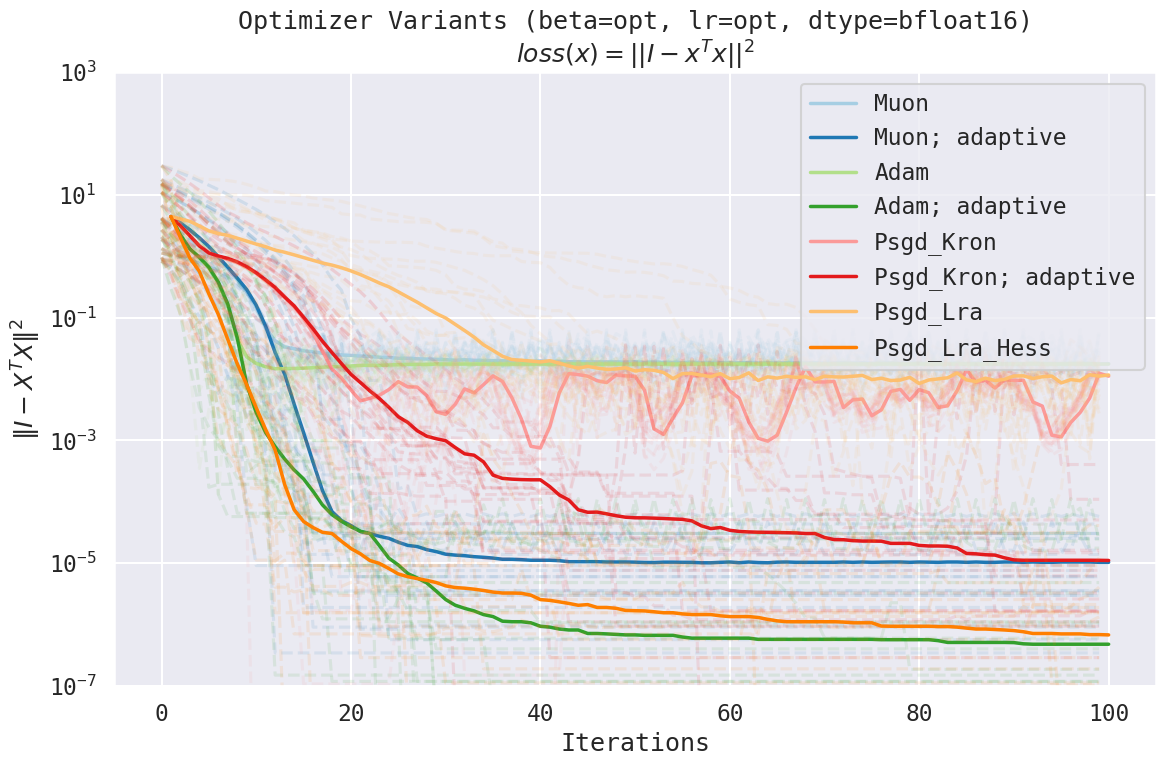

In [6]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_bfloat16_beta=opt.png",
    dtype=jnp.bfloat16,
    b=10000,
    num_iterations=100,
    optimizer_to_learning_rate_map={
        "muon": 1e-1,
        "adam": 1e-1,
        "psgd_kron": 5e-2,
        "psgd_lra": 5e-2,
        "psgd_lra_hess": 5e-1,
    },
    optimizer_to_beta_map={
        "muon": 0.5,
        "adam": 0.5,
        "psgd_kron": 0.0,
        "psgd_lra": 0.0,
        "psgd_lra_hess": 0.0,
    },
)

Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 13027 nan
Adam: 0 inf, 7486 nan
Adam; adaptive: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron; adaptive: 0 inf, 0 nan
PSGD: Using momentum.
Psgd_Lra: 0 inf, 4237 nan
PSGD: Using momentum.
Psgd_Lra_Hess: 0 inf, 4303 nan


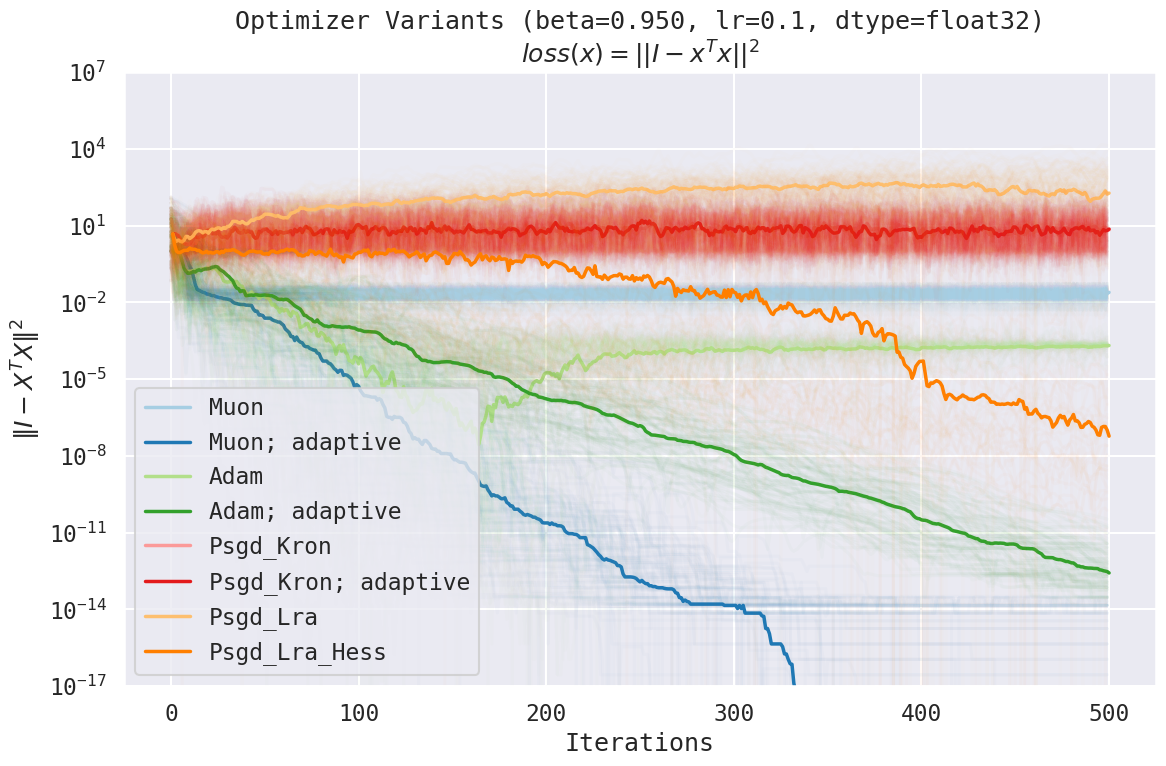

In [6]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants.png",
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.95,
)

In [ ]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_beta=0_5.png",
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.5,
)

Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 21181 nan
Adam: 0 inf, 0 nan
Adam; adaptive: 0 inf, 26898 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron; adaptive: 0 inf, 0 nan
PSGD: Using momentum.


Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 7870 nan
Adam: 0 inf, 0 nan
Adam; adaptive: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
Psgd_Kron: 0 inf, 0 nan
Psgd_Lra: 39 inf, 45159 nan


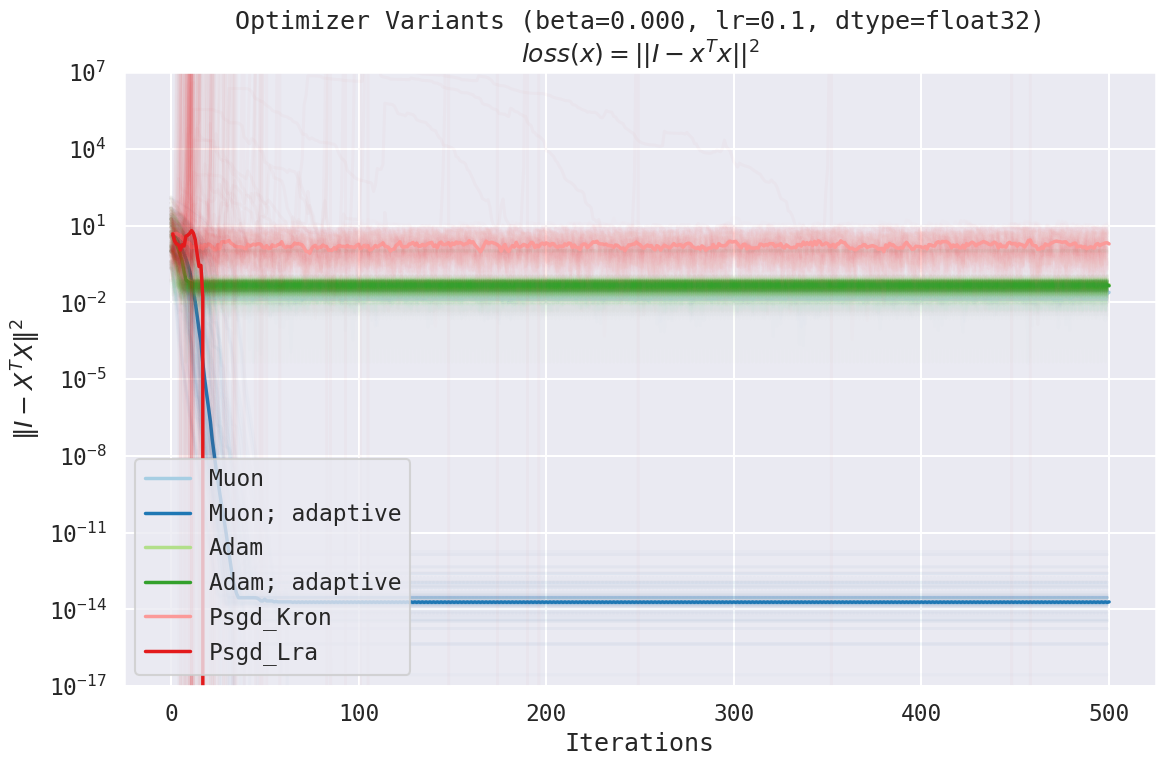

In [7]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_beta=0.png",
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.,
)

Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 0 nan
Adam: 0 inf, 0 nan
Adam; adaptive: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron: 0 inf, 10755 nan
PSGD: Using momentum.
Psgd_Lra: 10 inf, 8311 nan


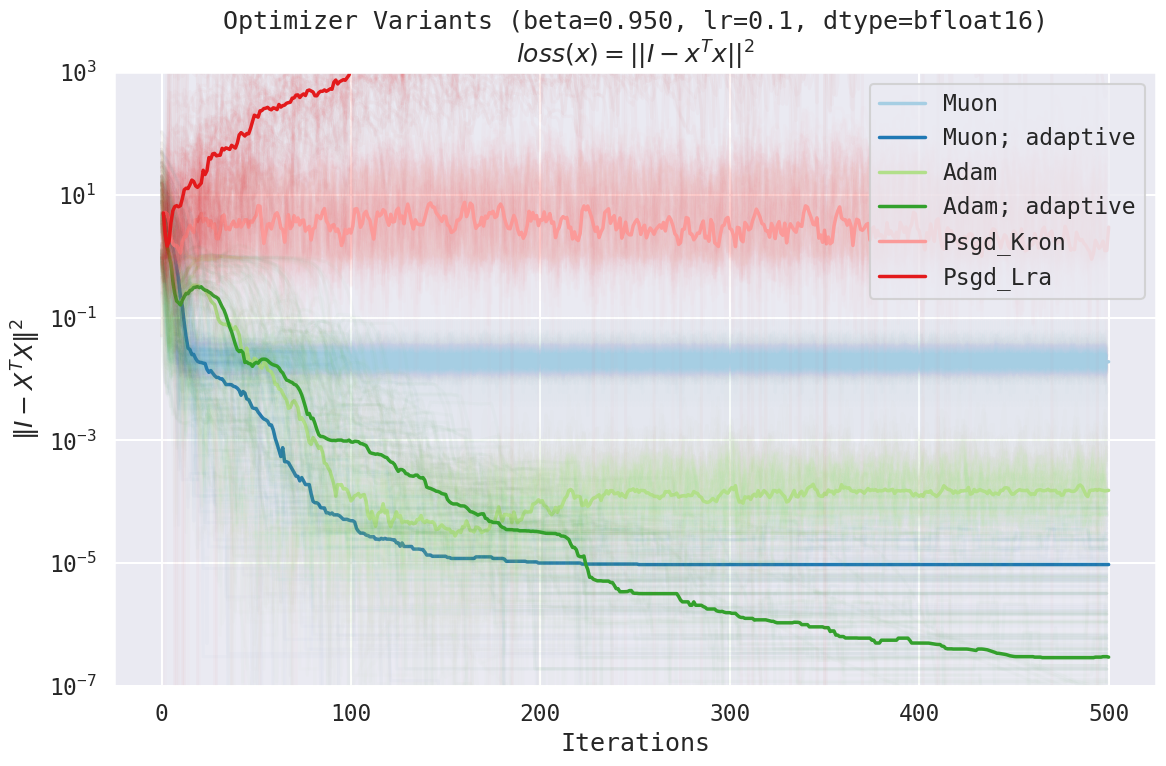

In [8]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_bfloat16.png",
    dtype=jnp.bfloat16,
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.95,
)

Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 0 nan
Adam: 0 inf, 0 nan
Adam; adaptive: 0 inf, 0 nan
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
Psgd_Kron: 0 inf, 3039 nan
PSGD: Using momentum.
Psgd_Lra: 29 inf, 4171 nan


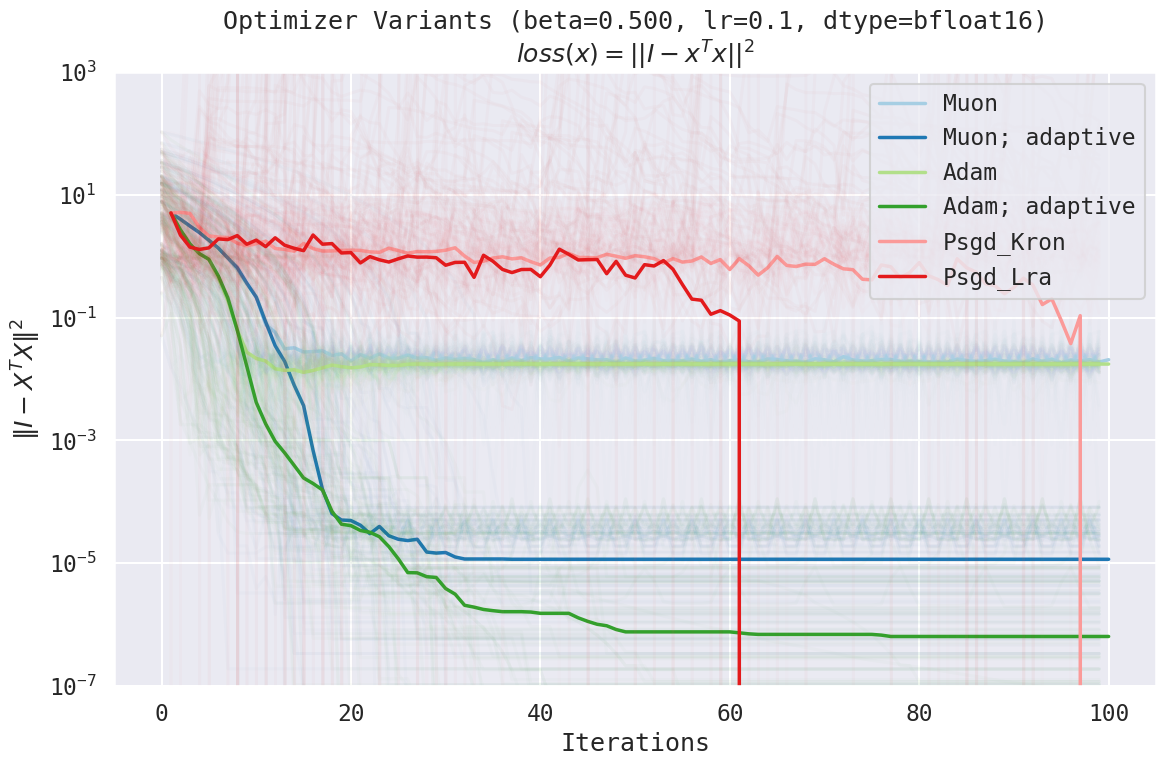

In [9]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_bfloat16_beta=0_5.png",
    dtype=jnp.bfloat16,
    num_iterations=100,
    learning_rate=1e-1,
    beta=0.5,
)

Muon: 0 inf, 0 nan
Muon; adaptive: 0 inf, 0 nan
Adam: 0 inf, 0 nan
Adam; adaptive: 0 inf, 0 nan
Psgd_Kron: 0 inf, 3528 nan
Psgd_Lra: 26 inf, 6354 nan


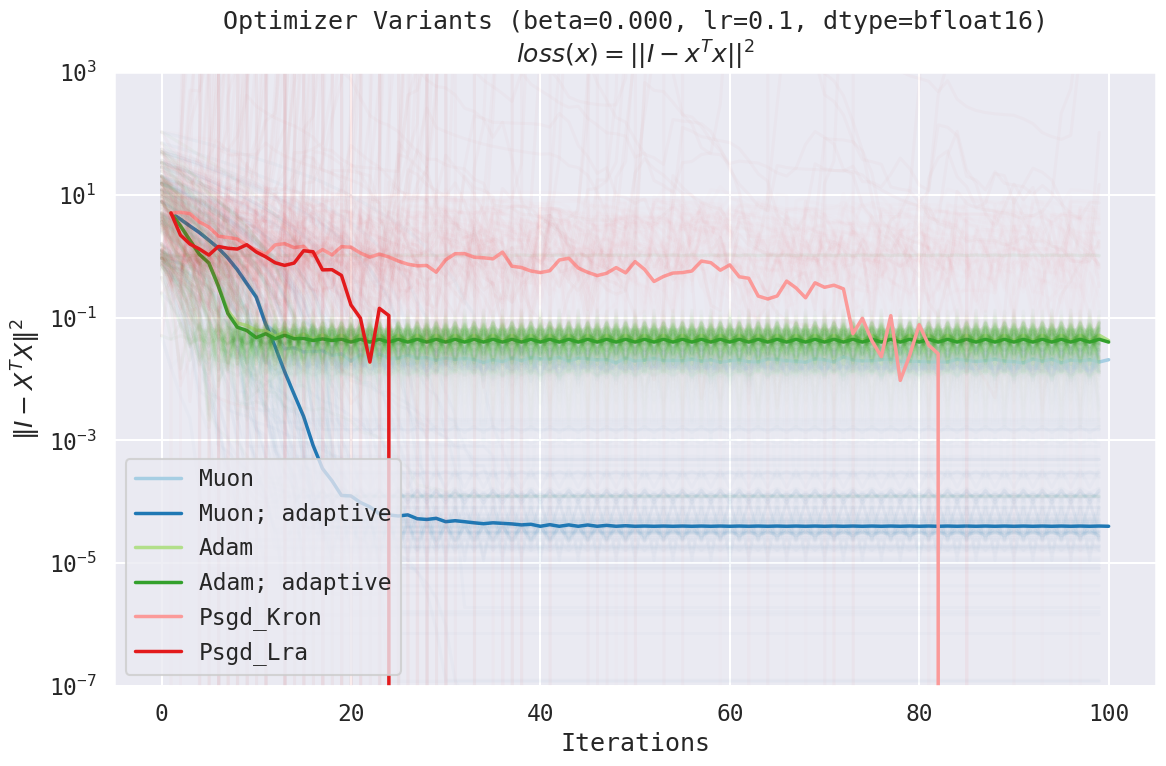

In [25]:
benchmark_optimizer_variants(
    savefile="images/optimizer_variants_bfloat16_beta=0.png",
    dtype=jnp.bfloat16,
    num_iterations=100,
    learning_rate=1e-1,
    beta=0.,
)

### Benchmark by momentum decay

In [12]:
def benchmark_muon_by_momentum_decay(
    savefile: str,
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    optimizer_class: str="muon",
    adaptive: bool=False,
    num_iterations: int=100,
    learning_rate: float=0.1,
    ns_steps: int=5,
    optimize_coeffs: bool=False,
):
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, shape=(b, n, n), dtype=dtype)

    betas = jnp.linspace(0, 0.999, 10).tolist()
    betas.insert(-1, 0.95)

    ns_coeffs=(
        (3.4445, -4.7750, 2.0315)
        if not optimize_coeffs
        else (
            (2.9145, -4.3663, 2.4515),
            (2.9131, -4.3582, 2.4446),
            (2.9030, -4.3145, 2.4106),
            (2.8317, -4.0251, 2.1928),
            (2.8392, -3.3535, 1.5149),
        )
    )

    results = {}
    for beta in betas:
        losses = batch_train(
            X,
            n,
            dtype,
            optimizer_class,
            num_iterations,
            learning_rate,
            ns_coeffs,
            ns_steps,
            beta,
            True,
            adaptive,
        )
        losses: jax.Array = jnp.where(jnp.isnan(losses), 0.0, losses)
        results[beta] = losses.astype(jnp.float32)

    palette = sns.color_palette("crest", len(betas))
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, (beta, all_losses) in enumerate(results.items()):
        x = jnp.arange(1, num_iterations+1)
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            x=x,
            y=median_losses,
            label=f"$\\beta$={beta:.3f}{'**' if beta == 0.95 else ''}",
            color=palette[idx],
            linewidth=2.5,
        )
        for losses in all_losses:
            sns.lineplot(
                losses,
                alpha=0.02,
                color=palette[idx],
            )
    plt.title(f"{'Adaptive ' if adaptive else ''}Muon: Limitation of Momentum (lr={learning_rate}, dtype={dtype.dtype})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    # plt.ylim(bottom=1e-16, top=1e2)
    plt.yscale("log")
    plt.legend(title=f"$\\beta$ Values", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()
    return results

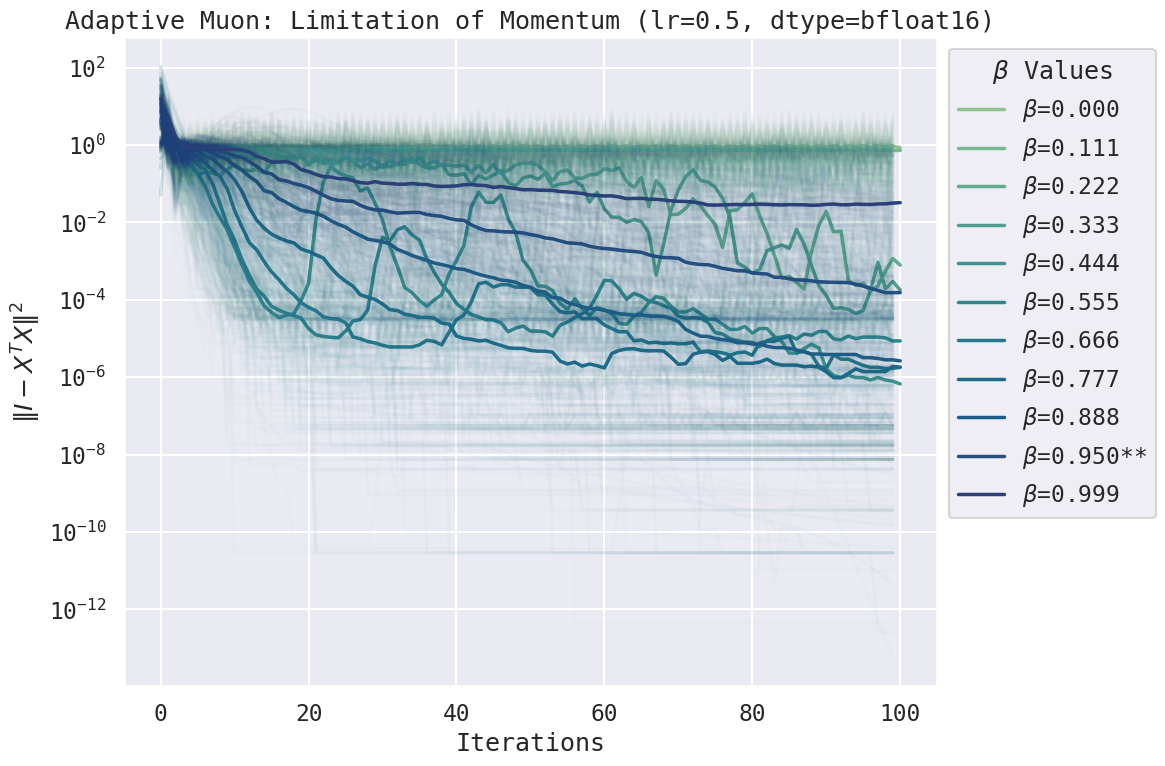

In [13]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adam_by_momentum_decay.png",
    optimizer_class="adam",
    dtype=jnp.bfloat16,
    learning_rate=0.5,
    adaptive=True,
    optimize_coeffs=False,
)

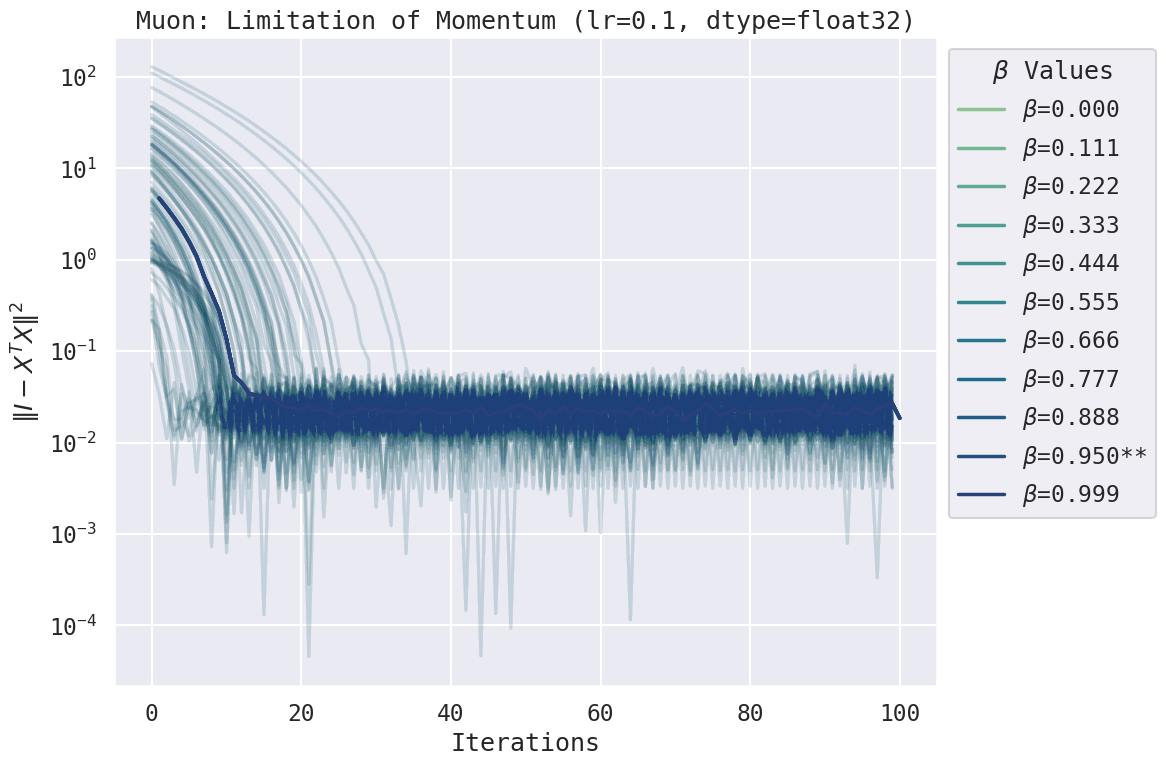

In [14]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/muon_by_momentum_decay.png",
    adaptive=False,
    optimize_coeffs=False,
)

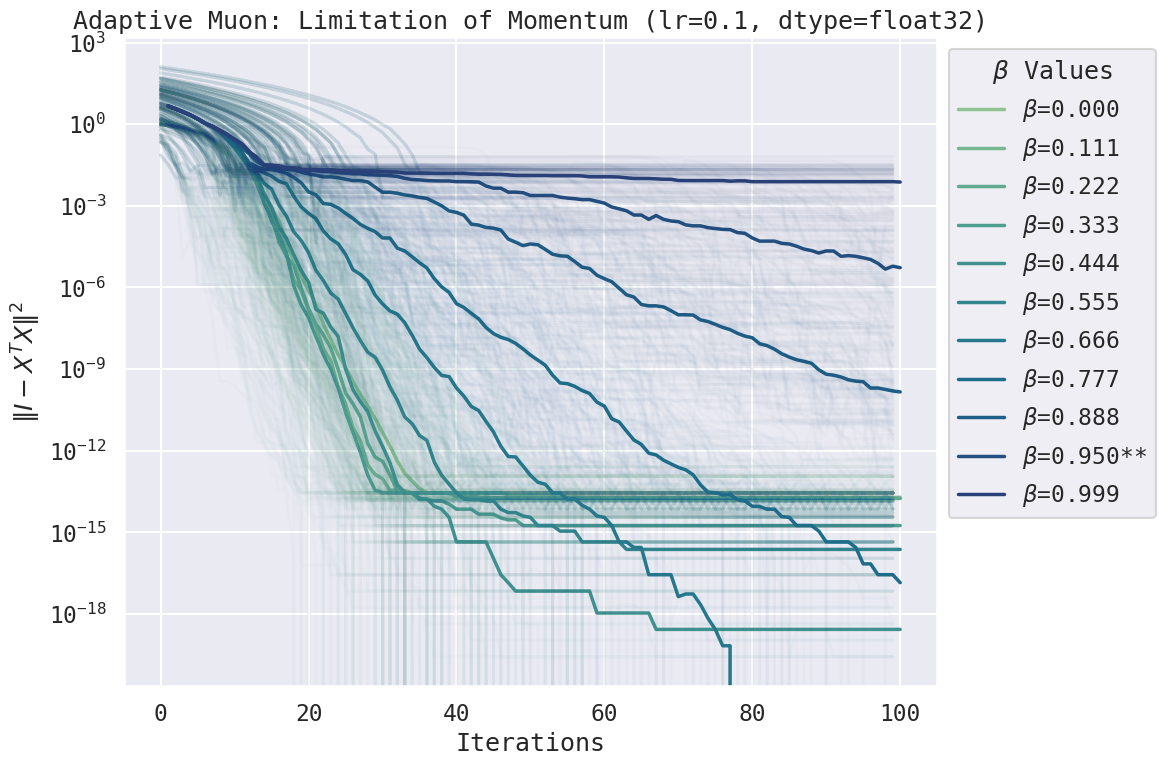

In [15]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay.png",
    adaptive=True,
    optimize_coeffs=False,
)

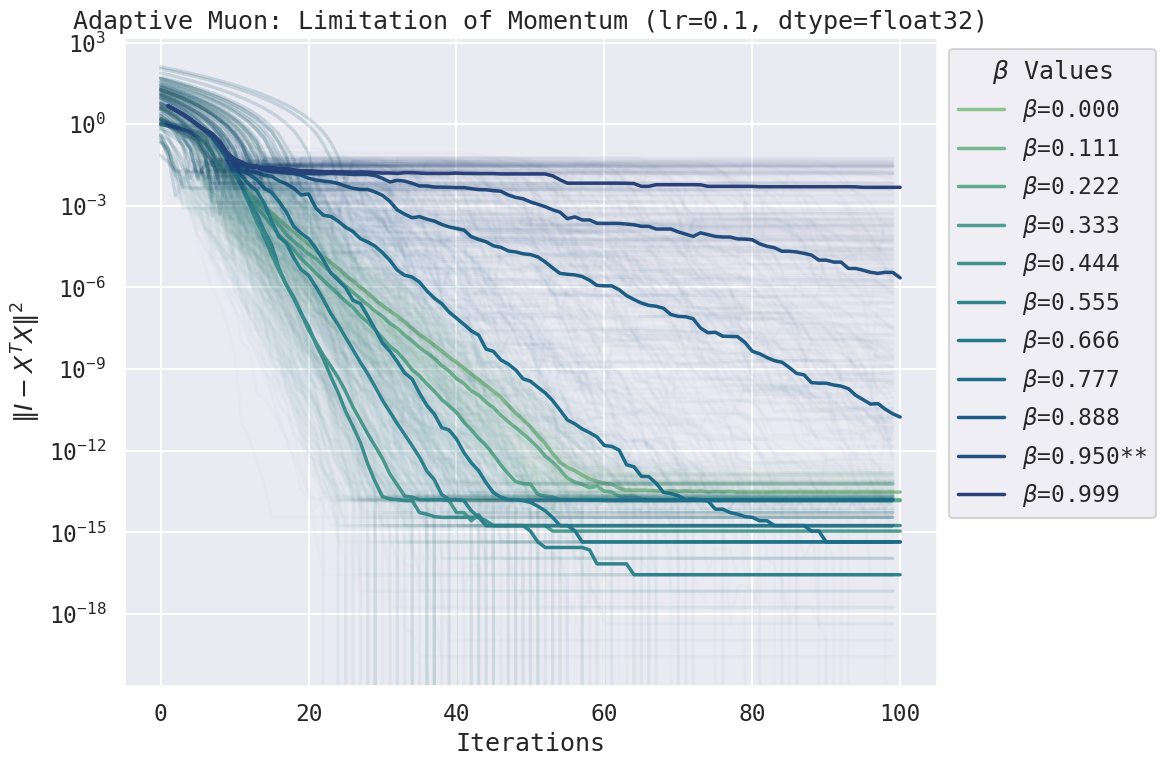

In [16]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt.png",
    adaptive=True,
    optimize_coeffs=True,
)

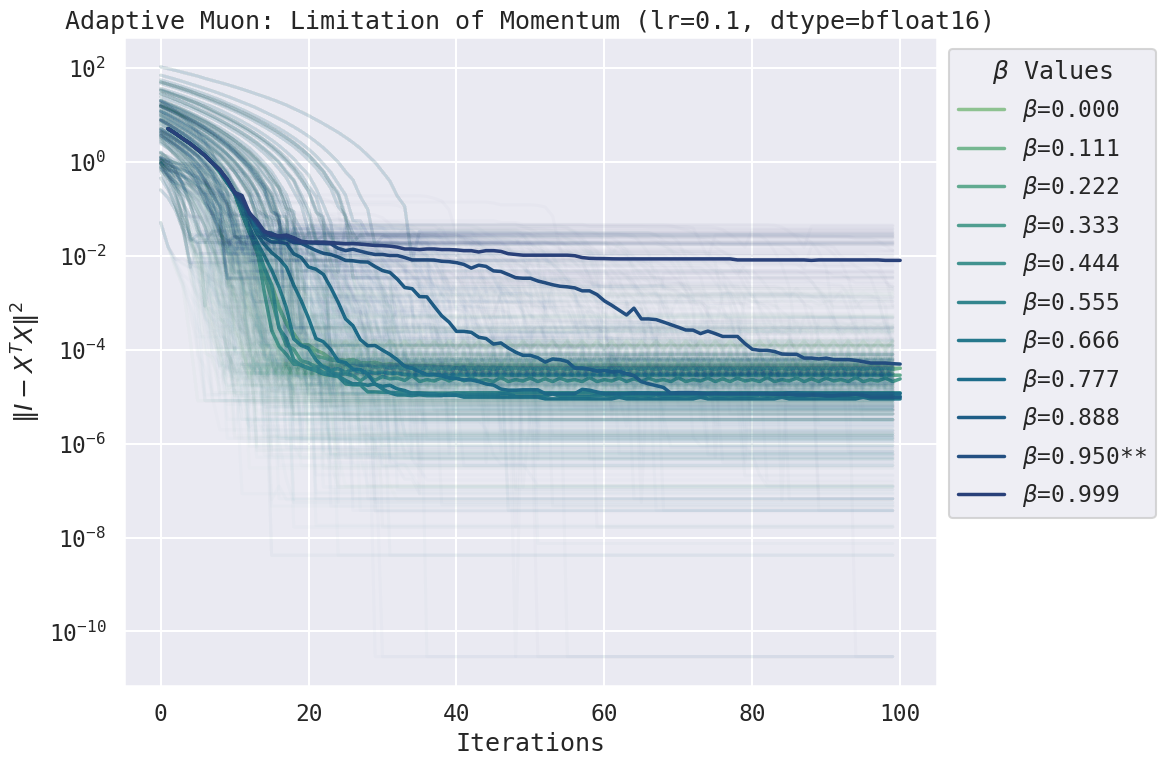

In [17]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_bfloat16.png",
    adaptive=True,
    optimize_coeffs=False,
    dtype=jnp.bfloat16,
)

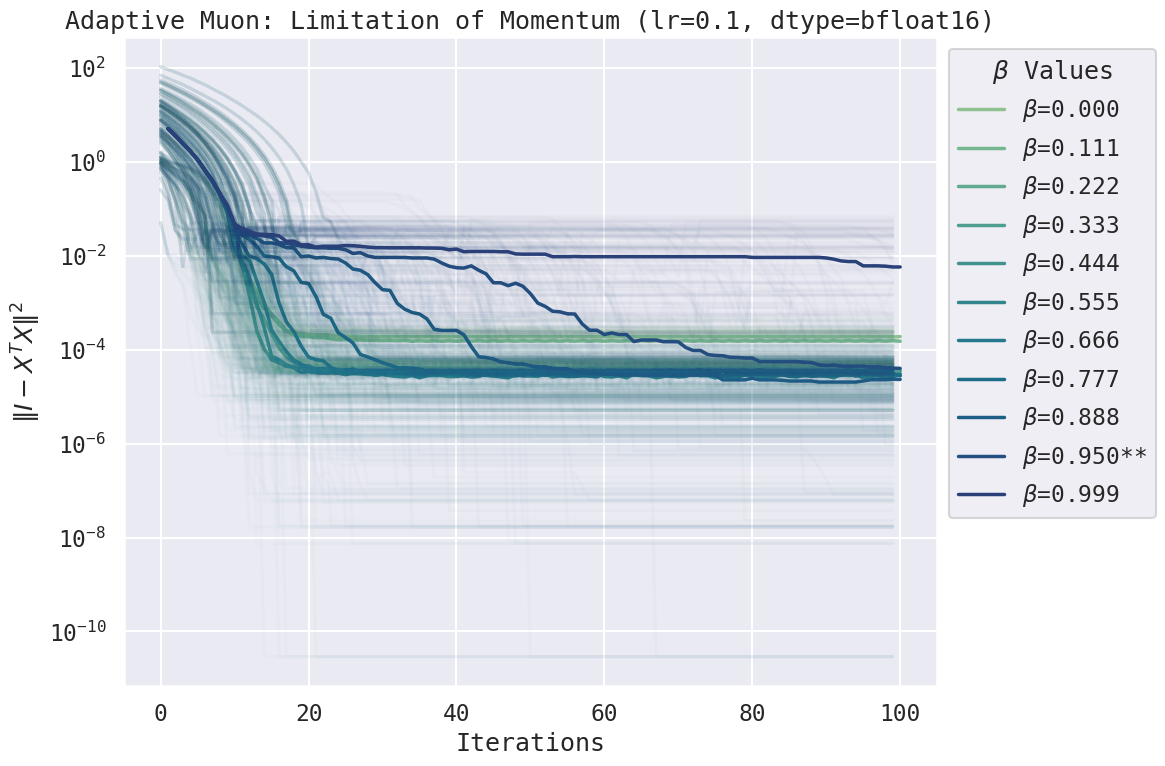

In [18]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt_bfloat16.png",
    adaptive=True,
    optimize_coeffs=True,
    dtype=jnp.bfloat16,
)

### Benchmark convergence/divergence rates

In [19]:
key = jax.random.PRNGKey(0)

b = 1000
n = 2
# dtype = jnp.float32
dtype = jnp.bfloat16
X = jax.random.normal(key, shape=(b, n, n), dtype=dtype)

In [20]:
num_iterations = 500
ns_coeffs = (3.4445, -4.7750, 2.0315)
ns_steps = 5
nesterov = True

lr_batch_train = jax.vmap(batch_train, in_axes=(None, None, None, None, None, 0, None, None, None, None, None))
learning_rates = jnp.logspace(-3, 0, 10, base=10)

results = {}
for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra"]:
    for adaptive in [False, True]:
        if optimizer_class in ["psgd_kron", "psgd_lra"] and adaptive:
            continue
        if optimizer_class in ["psgd_kron", "psgd_lra"]:
            beta = 0.0
        else:
            beta = 0.5
        losses = lr_batch_train(
            X,
            n,
            dtype,
            optimizer_class,
            num_iterations,
            learning_rates,
            ns_coeffs,
            ns_steps,
            beta,
            nesterov,
            adaptive,
        )
        losses = jnp.where(jnp.isnan(losses), 0.0, losses)

        divergence_ratio = (losses[:,:,-1] > 1).sum(axis=1) / b
        soft_convergence_ratio = (losses[:,:,-1] < 1e-3).sum(axis=1) / b
        hard_convergence_ratio = (losses[:,:,-1] < 1e-6).sum(axis=1) / b
        results[(optimizer_class, adaptive)] = (
            divergence_ratio,
            soft_convergence_ratio,
            hard_convergence_ratio,
        )

/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tra

PSGD Preconditioners size: 8 elements, 0.00 MB


/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.batching.BatchTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:6695: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:6696: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/leloykun/anaconda3/envs/nanogpt/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.

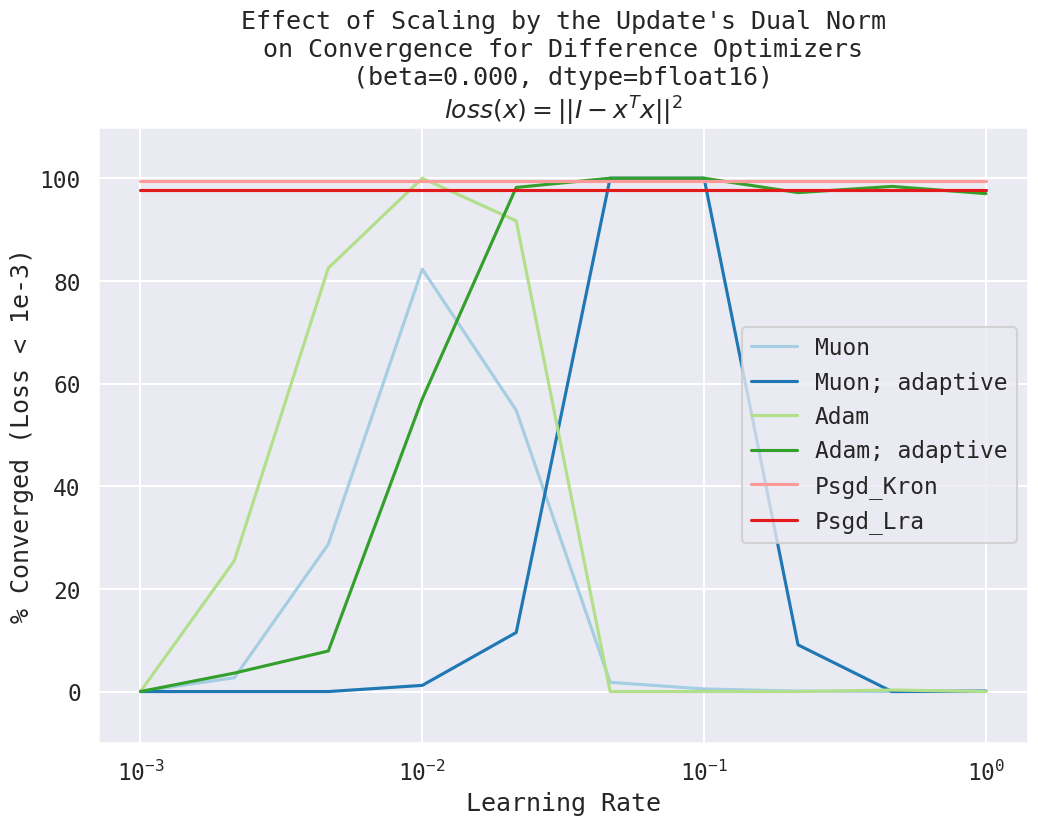

In [21]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=soft_convergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title(f"Effect of Scaling by the Update's Dual Norm\non Convergence for Difference Optimizers\n(beta={beta:.3f}, dtype={dtype.dtype})\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Converged (Loss < 1e-3)")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

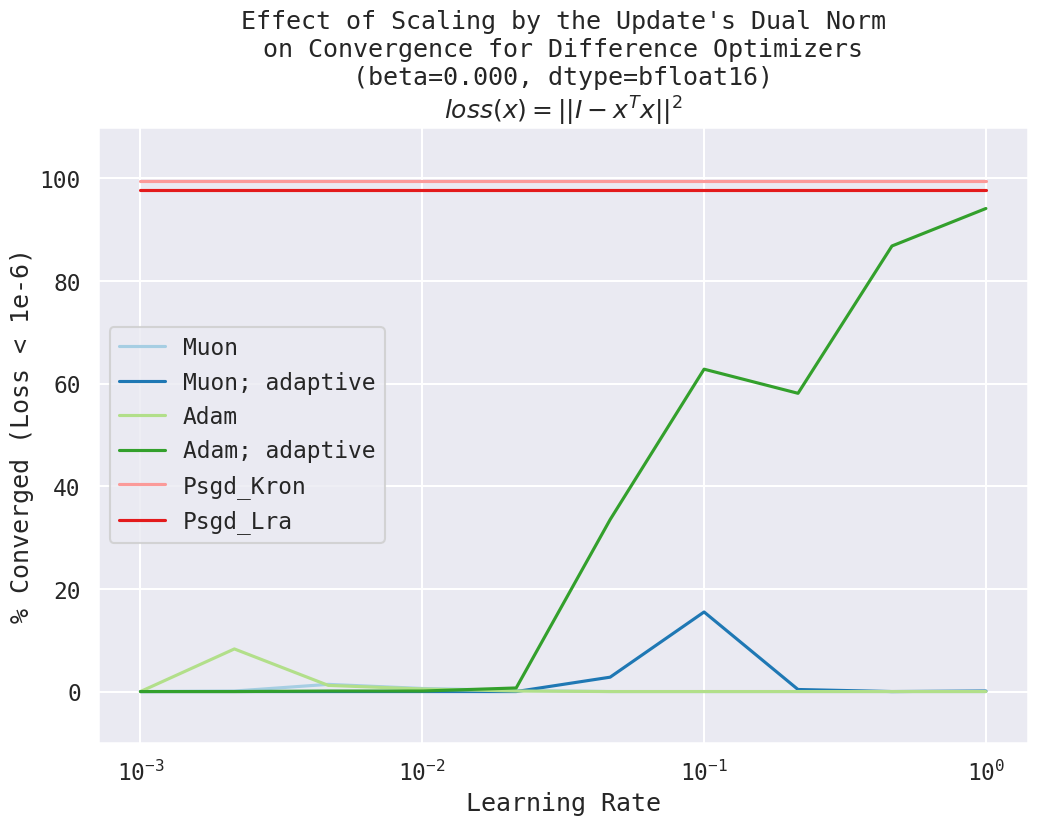

In [22]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=hard_convergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title(f"Effect of Scaling by the Update's Dual Norm\non Convergence for Difference Optimizers\n(beta={beta:.3f}, dtype={dtype.dtype})\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Converged (Loss < 1e-6)")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

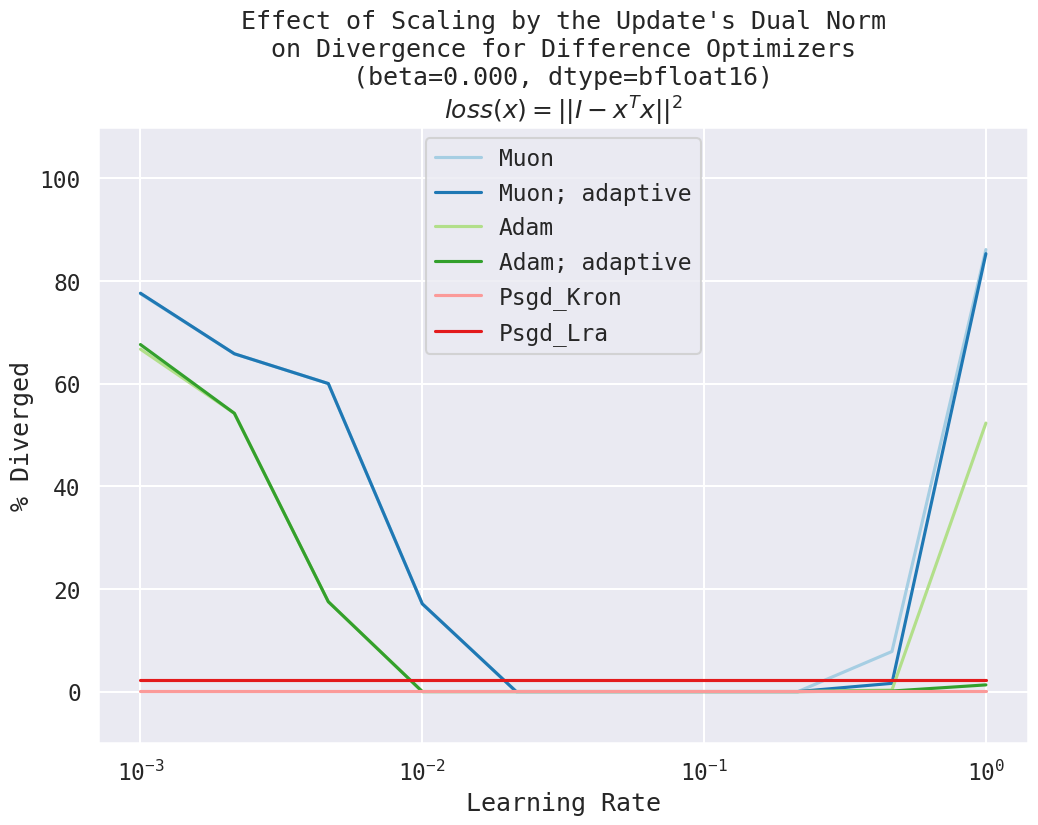

In [23]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=divergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title(f"Effect of Scaling by the Update's Dual Norm\non Divergence for Difference Optimizers\n(beta={beta:.3f}, dtype={dtype.dtype})\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Diverged")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

In [24]:
for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra"]:
    for adaptive in [False, True]:
        if optimizer_class in ["psgd_kron", "psgd_lra"] and adaptive:
            continue
        print(f"{optimizer_class = }, {adaptive = }")
        print("   lr   | # >1  | # <1e-3 | # <1e-6")
        print("------+-------+---------+--------")
        for lr in jnp.logspace(-3, 0, 10, base=10):
            lr = lr.item()
            results = batch_train(
                X,
                n,
                dtype,
                optimizer_class,
                num_iterations,
                lr,
                ns_coeffs,
                ns_steps,
                0.0 if optimizer_class in ["psgd_kron", "psgd_lra"] else 0.5,
                nesterov,
                adaptive,
            )
            results = jnp.where(jnp.isnan(results), 0.0, results)
            print(f"{lr:.1e} | {(results[:,-1] > 1).sum():<5} | {(results[:,-1] < 1e-3).sum():<7} | {(results[:,-1] < 1e-6).sum()}")
        print()

optimizer_class = 'muon', adaptive = False
   lr   | # >1  | # <1e-3 | # <1e-6
------+-------+---------+--------
1.0e-03 | 775   | 0       | 0
2.2e-03 | 658   | 27      | 1
4.6e-03 | 600   | 287     | 14
1.0e-02 | 171   | 825     | 9
2.2e-02 | 0     | 568     | 6
4.6e-02 | 0     | 22      | 0
1.0e-01 | 0     | 3       | 0
2.2e-01 | 0     | 0       | 0
4.6e-01 | 75    | 0       | 0
1.0e+00 | 861   | 0       | 0

optimizer_class = 'muon', adaptive = True
   lr   | # >1  | # <1e-3 | # <1e-6
------+-------+---------+--------
1.0e-03 | 776   | 0       | 0
2.2e-03 | 658   | 0       | 0
4.6e-03 | 600   | 0       | 0
1.0e-02 | 171   | 12      | 0
2.2e-02 | 0     | 119     | 0
4.6e-02 | 0     | 1000    | 23
1.0e-01 | 0     | 1000    | 145
2.2e-01 | 0     | 72      | 1
4.6e-01 | 12    | 0       | 0
1.0e+00 | 853   | 1       | 1

optimizer_class = 'adam', adaptive = False
   lr   | # >1  | # <1e-3 | # <1e-6
------+-------+---------+--------
1.0e-03 | 667   | 0       | 0
2.2e-03 | 542   | 254     